# TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL
- 이 섹션에서는 **보행자 검출 및 분할 목적의 Penn-Fudan 데이터셋** 에 사전학습된 **MASK R-CNN** 모델을 **finetuning** 해볼 것임
- 해당 데이터셋은 345 명의 보행자로 이루어진 170장의 이미지로 구성됨
- 여기선 객체 분할 모델을 custom 데이터셋으로 학습할 때 새로운 feature 들을 어떻게 사용하는지 보겠음

---
# 1. Defining the Dataset
- 물체 검출, 객체 분할, 키포인트 검출 모델을 학습시키기 위한 데이터셋 구성은 아래를 참조하면 됨
- 데이터셋은 ```torch.utils.data.Dataset``` 을 상속하고 ```len, getitem``` 메서드를 구현해야 함


- 신경써야할 부분은 역시 **```getitem```** 메서드임
>**image** : ```(H, W)``` 크기의 PIL 이미지  
>**target** : 다음 정보가 담긴 dictionary
    - **```boxes (FloatTensor[N, 4])```** : ```N``` 개의 바운딩 박스 좌표 ```[x0, x1, y0, y1]```. 좌표의 범위는 0에서 W, 0에서 H 임 
    - **```labels (Int64Tensor[N])```** : 각 바운딩 박스의 라벨. ```0``` 은 배경 클래스를 의미
    - **```image_id (Int64Tensor[1])```** : 이미지의 식별자. 전체 데이터셋에 대해 **유일해야 함**
    - **```area (Tensor[N])```** : 바운딩 박스의 면적. 이는 **COCO metric** 으로 평가에 사용됨
    - **```iscrowd (UInt8Tensor[N])```** : iscrowd=True 로 설정된 객체에 대해선 평가 단계에서 무시됨
    - (optional) **```masks (UInt8Tensor[N, J, W])```** : 각 객체에 대한 분할 마스크
    - (optional) **```keypoints (FlaotTensor[N, K. 3])```** : N 개의 객체에 대해 K 개의 키포인트가 있을 때 ```[x, y, visibility]``` 로 구성. visibility=0 이면 키포인트가 보이지 않다는 뜻
    

>**```labels```** 에 대한 주의점
>- ```0``` 은 배경에 해당하는 클래스임
>- 만약 자신의 데이터셋이 배경을 포함하지 않는다면 클래스 ```0```은 없어야 함
>- 예를 들어 개, 고양이 둘 중 하나를 분류하는 거라면 (0, 1)이 아니라 (1, 2)로 해야 함

>**추가 고려 사항**
>- 학습 중에 각 배치가 비슷한 **aspect ratio** 로 이루어지길 원한다면 ```get_height_and_width``` 메서드를 구현해야 함
>- 이 메서드는 이미지의 height 와 width 를 반환함
>- 이 메서드를 따로 구현하지 않으면 ```__getitem__``` 으로 데이터셋의 모든 요소에 대해 적용해야 하는데 이는 메모리 사용이 크고 속도가 느려짐

---
# 2. Writing a custom dataset for PennFudan
- **PennFudan 데이터셋** 을 파이토치의 사용자 정의 데이터셋으로 구현해 보겠음
- 우선 데이터셋을 다운받아야 함

In [1]:
import os
import numpy as np
import torch
from PIL import Image

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1: ]
        
        masks = mask == obj_ids[:, None, None]
        
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs, ), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs, ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)

---
# 3. Defining your model
- 이 튜토리얼에선 **Mask R-CNN** 모델을 사용할 것
- Mask R-CNN 은 **Faster R-CNN** 을 기반으로 함.
>**torchvision modelzoo** 로부터 모델을 가져와 파인튜닝하는 두 가지 상황
>1. 사전학습된 모델로 시작하여 마지막 출력층판 파인튜닝하는 경우
>2. 모델의 **백본**을 다른 모델로 대체하는 경우

## 3.1 Finetuning from a pretrained model
- COCO 데이터셋에 사전학습된 모델로 시작한다고 가정
- 사전학습된 모델을 우리 데이터셋의 클래스에 맞게 파인튜닝할 것

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features  # 분류를 위한 입력 feature 의 갯수 파악
print(in_features)

# 사전학습된 head 를 새로운 모델로 대체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

1024


## 3.2 Modifying the model to add a different backbone

In [3]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(pretrained=True).features

backbone.out_channels = 1200

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ),
                                  aspect_ratios=((0.5, 1.0, 2.0), ))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                               output_size=7,
                                               sampling_ratio=2)

model = FasterRCNN(backbone,
                  num_classes = 2,
                  rpn_anchor_generator = anchor_generator,
                  box_roi_pool = roi_pooler)

## 3.3 An Instance segmentation model for PennFudan Dataset
- 현재 우리 상황은 데이터셋 크기가 작고 사전학습된 모델을 파인튜닝하는 것이 좋음
- 따라서 첫 번째 케이스대로 진행할 것

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model

---
# 4. Putting everything together
- ```reference/detection``` 에는 모델의 학습과 평가를 도와주는 많은 함수가 있음
- 여기선 ```reference/detection/engine.py, utils.py, transforms.py``` 를 이용해 보겠음
- 사용하려면 ```reference/detection``` 폴더를 지금 사용하고 있는 폴더에 복사하면 됨

In [5]:
import references.detection.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

---
# 5. Testing ```forward()``` method (Optional)
- 데이터셋을 iterate 하기 전에 샘플 데이터에 대해 모델이 어떻게 동작하는지 보는 것이 좋음

In [6]:
import references.detection.utils as utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = PennFudanDataset("../../datasets/PennFudanPed", get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
)

imgs, targets = next(iter(data_loader))
imgs = list(img for img in imgs)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(imgs, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

- 이제 학습과 검증이 이뤄지는 **main** 함수를 작성

In [7]:
import engine
import utils

def main():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    num_classes = 2
    dataset = PennFudanDataset("../../datasets/PennFudanPed", get_transform(train=True))
    dataset_test = PennFudanDataset("../../datasets/PennFudanPed", get_transform(train=False))
    
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[: -50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50: ])
    
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
    )
    
    model = get_model_instance_segmentation(num_classes)
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                  step_size=3,
                                                  gamma=0.1)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        engine.train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        lr_scheduler.step()
        engine.evaluate(model, data_loader_test, device=device)
    
    print("That's it!")
    return model

In [8]:
torch.cuda.set_per_process_memory_fraction(0.7)
torch.cuda.empty_cache()
total_memory = torch.cuda.get_device_properties(0)
print(total_memory)

_CudaDeviceProperties(name='GeForce GTX 1660 SUPER', major=7, minor=5, total_memory=6144MB, multi_processor_count=22)


In [9]:
model = main()

Epoch: [0]  [ 0/60]  eta: 0:02:10  lr: 0.000090  loss: 2.9899 (2.9899)  loss_classifier: 0.5933 (0.5933)  loss_box_reg: 0.3445 (0.3445)  loss_mask: 1.9995 (1.9995)  loss_objectness: 0.0488 (0.0488)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 2.1682  data: 0.0210  max mem: 2724
Epoch: [0]  [10/60]  eta: 0:00:38  lr: 0.000936  loss: 1.2506 (1.6991)  loss_classifier: 0.3976 (0.4165)  loss_box_reg: 0.2809 (0.3047)  loss_mask: 0.6493 (0.9498)  loss_objectness: 0.0172 (0.0227)  loss_rpn_box_reg: 0.0038 (0.0054)  time: 0.7734  data: 0.0280  max mem: 2857
Epoch: [0]  [20/60]  eta: 0:00:29  lr: 0.001783  loss: 0.7789 (1.2084)  loss_classifier: 0.2105 (0.2968)  loss_box_reg: 0.2273 (0.2686)  loss_mask: 0.3359 (0.6203)  loss_objectness: 0.0111 (0.0169)  loss_rpn_box_reg: 0.0057 (0.0059)  time: 0.6727  data: 0.0268  max mem: 3287
Epoch: [0]  [30/60]  eta: 0:00:21  lr: 0.002629  loss: 0.5926 (0.9872)  loss_classifier: 0.1249 (0.2300)  loss_box_reg: 0.2212 (0.2528)  loss_mask: 0.2024 (0.4842)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:39  lr: 0.005000  loss: 0.2617 (0.2617)  loss_classifier: 0.0435 (0.0435)  loss_box_reg: 0.0752 (0.0752)  loss_mask: 0.1329 (0.1329)  loss_objectness: 0.0080 (0.0080)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 0.6649  data: 0.0290  max mem: 3287
Epoch: [2]  [10/60]  eta: 0:00:30  lr: 0.005000  loss: 0.2433 (0.2280)  loss_classifier: 0.0331 (0.0313)  loss_box_reg: 0.0715 (0.0672)  loss_mask: 0.1300 (0.1252)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0026 (0.0031)  time: 0.6170  data: 0.0236  max mem: 3287
Epoch: [2]  [20/60]  eta: 0:00:25  lr: 0.005000  loss: 0.2238 (0.2360)  loss_classifier: 0.0304 (0.0304)  loss_box_reg: 0.0590 (0.0681)  loss_mask: 0.1300 (0.1329)  loss_objectness: 0.0003 (0.0011)  loss_rpn_box_reg: 0.0029 (0.0035)  time: 0.6402  data: 0.0253  max mem: 3287
Epoch: [2]  [30/60]  eta: 0:00:19  lr: 0.005000  loss: 0.2459 (0.2398)  loss_classifier: 0.0223 (0.0311)  loss_box_reg: 0.0587 (0.0678)  loss_mask: 0.1423 (0.1355)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:00:46  lr: 0.000500  loss: 0.3294 (0.3294)  loss_classifier: 0.0402 (0.0402)  loss_box_reg: 0.0863 (0.0863)  loss_mask: 0.1995 (0.1995)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.7782  data: 0.0400  max mem: 3287
Epoch: [4]  [10/60]  eta: 0:00:34  lr: 0.000500  loss: 0.2013 (0.2114)  loss_classifier: 0.0272 (0.0304)  loss_box_reg: 0.0378 (0.0510)  loss_mask: 0.1171 (0.1260)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0034 (0.0031)  time: 0.6830  data: 0.0266  max mem: 3287
Epoch: [4]  [20/60]  eta: 0:00:26  lr: 0.000500  loss: 0.1772 (0.1966)  loss_classifier: 0.0234 (0.0278)  loss_box_reg: 0.0355 (0.0452)  loss_mask: 0.1093 (0.1196)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0033 (0.0031)  time: 0.6660  data: 0.0253  max mem: 3287
Epoch: [4]  [30/60]  eta: 0:00:20  lr: 0.000500  loss: 0.1671 (0.1898)  loss_classifier: 0.0170 (0.0263)  loss_box_reg: 0.0286 (0.0419)  loss_mask: 0.1014 (0.1180)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:00:44  lr: 0.000050  loss: 0.1500 (0.1500)  loss_classifier: 0.0208 (0.0208)  loss_box_reg: 0.0273 (0.0273)  loss_mask: 0.0983 (0.0983)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.7442  data: 0.0420  max mem: 3287
Epoch: [6]  [10/60]  eta: 0:00:33  lr: 0.000050  loss: 0.1500 (0.1734)  loss_classifier: 0.0207 (0.0234)  loss_box_reg: 0.0273 (0.0381)  loss_mask: 0.1004 (0.1086)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0032 (0.0028)  time: 0.6720  data: 0.0276  max mem: 3287
Epoch: [6]  [20/60]  eta: 0:00:27  lr: 0.000050  loss: 0.1772 (0.1851)  loss_classifier: 0.0229 (0.0263)  loss_box_reg: 0.0345 (0.0407)  loss_mask: 0.1141 (0.1145)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0024 (0.0028)  time: 0.6805  data: 0.0272  max mem: 3287
Epoch: [6]  [30/60]  eta: 0:00:20  lr: 0.000050  loss: 0.1895 (0.1878)  loss_classifier: 0.0265 (0.0267)  loss_box_reg: 0.0353 (0.0420)  loss_mask: 0.1141 (0.1154)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:46  lr: 0.000050  loss: 0.1549 (0.1549)  loss_classifier: 0.0209 (0.0209)  loss_box_reg: 0.0234 (0.0234)  loss_mask: 0.1102 (0.1102)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.7722  data: 0.0270  max mem: 3287
Epoch: [8]  [10/60]  eta: 0:00:33  lr: 0.000050  loss: 0.1590 (0.1747)  loss_classifier: 0.0261 (0.0272)  loss_box_reg: 0.0361 (0.0356)  loss_mask: 0.1051 (0.1088)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0025 (0.0026)  time: 0.6773  data: 0.0286  max mem: 3287
Epoch: [8]  [20/60]  eta: 0:00:27  lr: 0.000050  loss: 0.1590 (0.1788)  loss_classifier: 0.0261 (0.0263)  loss_box_reg: 0.0314 (0.0369)  loss_mask: 0.1034 (0.1123)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0025 (0.0028)  time: 0.6707  data: 0.0292  max mem: 3287
Epoch: [8]  [30/60]  eta: 0:00:20  lr: 0.000050  loss: 0.1662 (0.1841)  loss_classifier: 0.0262 (0.0276)  loss_box_reg: 0.0336 (0.0395)  loss_mask: 0.1074 (0.1134)  loss_ob

In [11]:
dataset = PennFudanDataset("../../datasets/PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset("../../datasets/PennFudanPed", get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[: -50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50: ])

img, _ = dataset_test[0]
model.eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
with torch.no_grad():
    pred = model([img.to(device)])

In [12]:
pred

[{'boxes': tensor([[ 90.2022,  62.3167, 235.9388, 340.5693],
          [244.1241,  53.8176, 300.9406, 350.2881],
          [247.2961,  20.4901, 347.4058, 365.2182]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9972, 0.9902, 0.0547], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...,

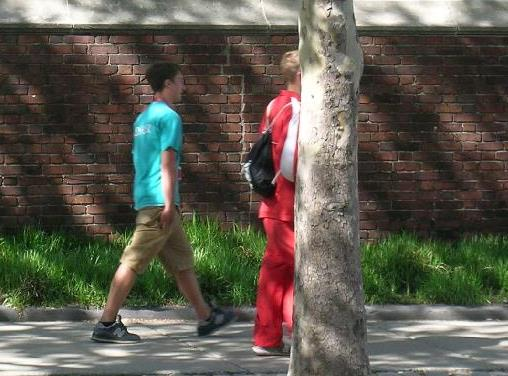

In [13]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

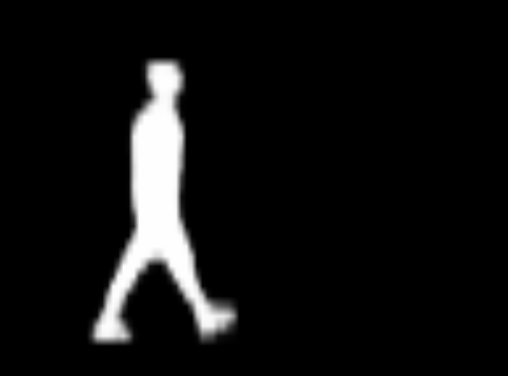

In [14]:
Image.fromarray(pred[0]["masks"][0, 0].mul(255).byte().cpu().numpy())